In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from pathlib import Path
import tkinter as tk
import os
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
x_train_path = Path('/kaggle/input/zphyr-test/goose_ex_val/x_train')
x_val_path = Path('/kaggle/input/zphyr-test/goose_ex_val/x_val')
y_train_path = Path('/kaggle/input/zphyr-test/goose_ex_val/y_train')
y_val_path = Path('/kaggle/input/zphyr-test/goose_ex_val/y_val')

In [44]:
# Función para cargar y procesar los datos
def load_data(x_path, y_path):
    X_data, Y_data = [], []
    num_points_list = []

    for x_file in Path(x_path).iterdir():
        if x_file.is_file() and x_file.suffix == '.csv':
            y_file = Path(y_path) / x_file.name.replace('x_', 'y_')

            x_df = pd.read_csv(x_file, header=None, skiprows=1)
            y_df = pd.read_csv(y_file, header=None, skiprows=1)

            x_features = x_df.iloc[:, [0, 1, 2]].astype(float).values
            labels = y_df.iloc[:, 0].values

            X_data.append(x_features)
            Y_data.append(labels)
            num_points_list.append(len(x_features))
    
    return X_data, Y_data, min(num_points_list)  # Retorna además el número mínimo de puntos

# Cargar datos y obtener la cantidad mínima de puntos
x_train, y_train, min_train_points = load_data(x_train_path, y_train_path)
x_val, y_val, min_val_points = load_data(x_val_path, y_val_path)

min_points = min(min_train_points, min_val_points)  # Definir la cantidad mínima global

In [45]:
def downsample_data(X_data, Y_data, num_points):
    X_downsampled, Y_downsampled = [], []
    for x, y in zip(X_data, Y_data):
        indices = np.random.permutation(len(x))[:num_points]  # Selección aleatoria
        X_downsampled.append(x[indices])
        Y_downsampled.append(y[indices])
    return np.array(X_downsampled), np.array(Y_downsampled)

# Aplicar el downsampling
x_train, y_train = downsample_data(x_train, y_train, min_points)
x_val, y_val = downsample_data(x_val, y_val, min_points)

In [ ]:
MAX_POINTS = min_points

def tnet(inputs, num_features):
    """
    Implementación de T-Net para aprender transformaciones afines.
    """
    x = layers.Conv1D(64, 1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Matriz de transformación (num_features x num_features)
    x = layers.Dense(num_features * num_features, kernel_initializer='zeros',
                     bias_initializer=tf.keras.initializers.Constant(tf.eye(num_features).numpy().flatten()))(x)
    transform_matrix = layers.Reshape((num_features, num_features))(x)

    # Aplicar la transformación correctamente
    def transform(inputs_and_matrix):
        inputs, matrix = inputs_and_matrix
        return tf.linalg.matmul(inputs, matrix)

    transformed_inputs = layers.Lambda(transform, output_shape=(None, num_features))([inputs, transform_matrix])

    return transformed_inputs  # Retorna los datos transformados

def build_pointnet(num_classes, input_dim=3):
    """
    Modelo PointNet con T-Net para clasificación punto a punto.
    """
    inputs = tf.keras.Input(shape=(None, input_dim))  # Entrada: N puntos con D características

    # Aplicar T-Net en la entrada para corregir la orientación de los puntos
    x = tnet(inputs, input_dim)

    # MLP Layers
    x = layers.Conv1D(64, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Aplicar T-Net en características para mejorar representaciones intermedias
    x = tnet(x, 64)

    x = layers.Conv1D(1024, 1, activation='relu')(x) # MLP variable (64, 256, 1024, 2048) Según las clases a segmentar y el tamaño del dataset, escalar en capas. 
    x = layers.BatchNormalization()(x)

    # Global Feature Aggregation
    global_features = layers.GlobalMaxPooling1D()(x)
    global_features = layers.RepeatVector(MAX_POINTS)(global_features)  # Repetir para cada punto
    global_features = layers.Conv1D(1024, 1, activation='relu')(global_features)

    # Concatenar características globales y locales
    x = layers.concatenate([x, global_features])

    # MLP final para clasificación
    x = layers.Conv1D(512, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv1D(256, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x) # Apagar 30%

    outputs = layers.Conv1D(num_classes, 1, activation='softmax')(x)  # Clasificación por punto

    return Model(inputs, outputs)

In [86]:
import tensorflow.keras.backend as K

def mean_iou(y_true, y_pred):
    num_classes = tf.shape(y_pred)[-1]  # Número de clases dinámico
    num_classes = tf.cast(num_classes, dtype=tf.int32)  # Asegurar tipo int32
    
    y_pred = tf.argmax(y_pred, axis=-1)  # Convertir probabilidades en clases
    y_pred = tf.cast(y_pred, dtype=tf.int32)  # Convertir y_pred a int32
    y_true = tf.cast(y_true, dtype=tf.int32)  # Asegurar que y_true también sea int32

    iou = tf.TensorArray(dtype=tf.float32, size=num_classes)  # Arreglo para IoU por clase

    def compute_iou(i, iou):
        """Función auxiliar para calcular IoU por clase"""
        intersection = K.sum(K.cast(tf.logical_and(y_pred == i, y_true == i), dtype=tf.float32))
        union = K.sum(K.cast(tf.logical_or(y_pred == i, y_true == i), dtype=tf.float32))
        iou_val = tf.cond(tf.equal(union, 0), lambda: tf.constant(0.0, dtype=tf.float32), lambda: intersection / union)  # Evita división por 0
        return i + 1, iou.write(i, iou_val)

    # Iterar sobre cada clase usando `tf.while_loop`
    _, iou = tf.while_loop(lambda i, _: i < num_classes, compute_iou, [tf.constant(0, dtype=tf.int32), iou])

    return K.mean(iou.stack())  # Devolver promedio de IoU

In [87]:
# Construir y compilar el modelo
pointnet_model = build_pointnet(num_classes=64, input_dim=3)
pointnet_model.compile(optimizer=Adam(learning_rate=0.000005), loss='sparse_categorical_crossentropy', metrics=['accuracy', mean_iou])

# Resumen del modelo
pointnet_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, None, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_272 (Conv1D)       │ (None, None, 64)       │            256 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_287   │ (None, None, 64)       │            256 │ conv1d_272[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_273 (Conv1D)       │ (None, None, 128)      │          8,320 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_288   │ (None, None, 128)      │            512 │ conv1d_273[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_274 (Conv1D)       │ (None, None, 1024)     │        132,096 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_289   │ (None, None, 1024)     │          4,096 │ conv1d_274[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_62   │ (None, 1024)           │              0 │ batch_normalization_2… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_129 (Dense)         │ (None, 512)            │        524,800 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_290   │ (None, 512)            │          2,048 │ dense_129[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_130 (Dense)         │ (None, 256)            │        131,328 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_291   │ (None, 256)            │          1,024 │ dense_130[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_131 (Dense)         │ (None, 9)              │          2,313 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_43 (Reshape)      │ (None, 3, 3)           │              0 │ dense_131[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_42 (Lambda)        │ (None, None, 3)        │              0 │ input_layer_23[0][0],  │
│                           │                        │                │ reshape_43[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_275 (Conv1D)  

 Total params: 5,006,409 (19.10 MB)

 Trainable params: 4,994,377 (19.05 MB)

 Non-trainable params: 12,032 (47.00 KB)

In [89]:
history = pointnet_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=28,  # Ajustar según los recursos
    batch_size=8,  # Ajustar según la memoria disponible
    verbose=1
)

Epoch 1/28
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 990ms/step - accuracy: 0.0176 - loss: 5.0520 - mean_iou: 0.0027 - val_accuracy: 0.0208 - val_loss: 4.7100 - val_mean_iou: 3.0945e-04
Epoch 2/28
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 668ms/step - accuracy: 0.0735 - loss: 4.3637 - mean_iou: 0.0085 - val_accuracy: 0.0208 - val_loss: 4.9907 - val_mean_iou: 3.0945e-04
Epoch 3/28
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 669ms/step - accuracy: 0.1399 - loss: 3.9811 - mean_iou: 0.0144 - val_accuracy: 0.0208 - val_loss: 5.1581 - val_mean_iou: 3.0945e-04
Epoch 4/28
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 670ms/step - accuracy: 0.2072 - loss: 3.6810 - mean_iou: 0.0201 - val_accuracy: 0.0208 - val_loss: 5.2606 - val_mean_iou: 3.0945e-04
Epoch 5/28
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 671ms/step - accuracy: 0.2766 - loss: 3.4167 - mean_iou: 0.0256 - val_accuracy: 0.0208 - val_loss: 5.2976 - val_mean_iou: 3.0945e-04
Epoch 6/28
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 672ms/step - accuracy: 0.3385 - loss: 3.1896 - mean_iou: 0.0305 - val_accuracy: 0.0

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

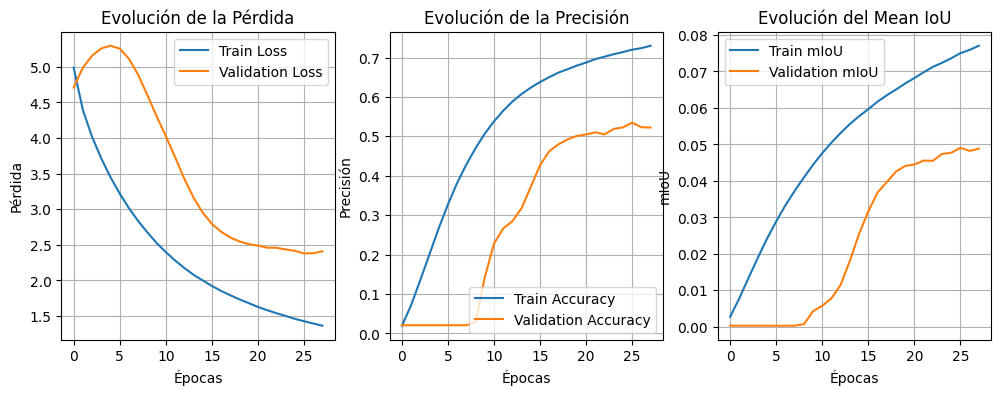

In [90]:
import matplotlib.pyplot as plt

# Extraer datos del historial
epochs = range(len(history.history['loss']))  # Número de épocas

# 1. Gráfico de pérdida (loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.grid()

# 2. Gráfico de Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la Precisión')
plt.legend()
plt.grid()

# 3. Gráfico de Mean IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, history.history['mean_iou'], label='Train mIoU')
plt.plot(epochs, history.history['val_mean_iou'], label='Validation mIoU')
plt.xlabel('Épocas')
plt.ylabel('mIoU')
plt.title('Evolución del Mean IoU')
plt.legend()
plt.grid()

# Mostrar todos los gráficos
plt.tight_layout


In [ ]:
history = pointnet_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,  # Ajustar según los recursos
    batch_size=2,  # Ajustar según la memoria disponible
    verbose=1
)

Epoch 1/20
162/162 - 51s 213ms/step - accuracy: 0.0542 - loss: 4.5165 - mean_iou: 0.0046 - val_accuracy: 0.0234 - val_loss: 5.3071 - val_mean_iou: 3.6071e-04
Epoch 2/20
162/162 - 31s 193ms/step - accuracy: 0.3067 - loss: 3.4498 - mean_iou: 0.0209 - val_accuracy: 0.0244 - val_loss: 5.4722 - val_mean_iou: 4.4073e-04
Epoch 3/20
162/162 - 31s 194ms/step - accuracy: 0.4273 - loss: 2.9155 - mean_iou: 0.0283 - val_accuracy: 0.1496 - val_loss: 4.4013 - val_mean_iou: 0.0048
Epoch 4/20
162/162 - 31s 194ms/step - accuracy: 0.5012 - loss: 2.5717 - mean_iou: 0.0333 - val_accuracy: 0.2210 - val_loss: 4.4648 - val_mean_iou: 0.0116
Epoch 5/20
162/162 - 31s 193ms/step - accuracy: 0.5487 - loss: 2.3301 - mean_iou: 0.0363 - val_accuracy: 0.3226 - val_loss: 4.7492 - val_mean_iou: 0.0185
Epoch 6/20
162/162 - 31s 194ms/step - accuracy: 0.6052 - loss: 2.0991 - mean_iou: 0.0409 - val_accuracy: 0.3670 - val_loss: 4.5859 - val_mean_iou: 0.0214
Epoch 7/20
162/162 - 31s 194ms/step - accuracy: 0.6241 - loss: 1.9553 - mean_iou: 0.0425 - val_accuracy: 0.3861 - val_loss: 5.5271 - val_mean_iou: 0.0228
Epoch 8/20
162/162 - 31s 194ms/step - accuracy: 0.6486 - loss: 1.8183 - mean_iou: 0.0445 - val_accuracy: 0.3714 - val_loss: 5.9920 - val_mean_iou: 0.0221
Epoch 9/20
162/162 - 31s 194ms/step - accuracy: 0.6652 - loss: 1.7296 - mean_iou: 0.0462 - val_accuracy: 0.3597 - val_loss: 6.7653 - val_mean_iou: 0.0213
Epoch 10/20
162/162 - 31s 194ms/step - accuracy: 0.6845 - loss: 1.6288 - mean_iou: 0.0480 - val_accuracy: 0.3739 - val_loss: 6.3488 - val_mean_iou: 0.0227
Epoch 11/20
162/162 - 31s 194ms/step - accuracy: 0.6972 - loss: 1.5369 - mean_iou: 0.0493 - val_accuracy: 0.3962 - val_loss: 5.4260 - val_mean_iou: 0.0230
Epoch 12/20
162/162 - 31s 194ms/step - accuracy: 0.7044 - loss: 1.4950 - mean_iou: 0.0506 - val_accuracy: 0.3449 - val_loss: 6.3189 - val_mean_iou: 0.0213
Epoch 13/20
162/162 - 31s 31s 194ms/step - accuracy: 0.7120 - loss: 1.4459 - mean_iou: 0.0521 - val_accuracy: 0.3866 - val_loss: 7.0743 - val_mean_iou: 0.0229
Epoch 14/20
162/162 - 31s 31s 193ms/step - accuracy: 0.7206 - loss: 1.3928 - mean_iou: 0.0530 - val_accuracy: 0.3747 - val_loss: 6.8292 - val_mean_iou: 0.0214
Epoch 15/20
162/162 - 31s 31s 193ms/step - accuracy: 0.7393 - loss: 1.3112 - mean_iou: 0.0543 - val_accuracy: 0.3636 - val_loss: 7.6521 - val_mean_iou: 0.0224
Epoch 16/20
162/162 - 31s 31s 193ms/step - accuracy: 0.7383 - loss: 1.2800 - mean_iou: 0.0553 - val_accuracy: 0.3588 - val_loss: 7.3359 - val_mean_iou: 0.0223
Epoch 17/20
162/162 - 31s 31s 194ms/step - accuracy: 0.7487 - loss: 1.2254 - mean_iou: 0.0567 - val_accuracy: 0.3664 - val_loss: 11.9435 - val_mean_iou: 0.0221
Epoch 18/20
162/162 - 31s 31s 194ms/step - accuracy: 0.7538 - loss: 1.1798 - mean_iou: 0.0567 - val_accuracy: 0.3286 - val_loss: 6.1531 - val_mean_iou: 0.0210
Epoch 19/20
162/162 - 31s 31s 193ms/step - accuracy: 0.7633 - loss: 1.1305 - mean_iou: 0.0590 - val_accuracy: 0.3284 - val_loss: 7.3802 - val_mean_iou: 0.0212
Epoch 20/20
162/162 - 31s 31s 194ms/step - accuracy: 0.7629 - loss: 1.0987 - mean_iou: 0.0593 - val_accuracy: 0.3834 - val_loss: 6.6958 - val_mean_iou: 0.0234

history = pointnet_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=28,  # Ajustar según los recursos
    batch_size=8,  # Ajustar según la memoria disponible
    verbose=1
)

### Ultimos 3 epoch

Epoch 1/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 736ms/step - accuracy: 0.8027 - loss: 1.0146 - mean_iou: 0.1029 - val_accuracy: 0.4788 - val_loss: 3.7700 - val_mean_iou: 0.0457  
Epoch 2/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 734ms/step - accuracy: 0.8066 - loss: 0.9914 - mean_iou: 0.1040 - val_accuracy: 0.4813 - val_loss: 3.6728 - val_mean_iou: 0.0462  
Epoch 3/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 733ms/step - accuracy: 0.8087 - loss: 0.9666 - mean_iou: 0.1057 - val_accuracy: 0.4772 - val_loss: 3.8498 - val_mean_iou: 0.0465  

[Open3D-PointNet2-Semantic3D](https://github.com/isl-org/Open3D-PointNet2-Semantic3D)